In [1]:
################################################################################################################################
#
# LSTM - JANSEN - STANDARD - DAILY
#
################################################################################################################################

#-------------------------------------------------------------------------------------------------------------------------------
# 'Train RMSE:   97.38 | Test RMSE:  141.26'
#-------------------------------------------------------------------------------------------------------------------------------

#===============================================================================================================================
# ENVIRONMENT: LIBRARIES, SETTINGS
#===============================================================================================================================
#pip install pandas-datareader

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

from pathlib import Path

import numpy as np
import pandas as pd
import pandas_datareader.data as web
import sklearn
import sklearn.preprocessing
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns

from scipy.stats import spearmanr

from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler

from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Activation
from tensorflow import keras

In [2]:
#===============================================================================================================================
# ENVIRONMENT: HARDWARE
#===============================================================================================================================
gpu_devices = tf.config.experimental.list_physical_devices('GPU')
if gpu_devices:
    print('Using GPU')
    tf.config.experimental.set_memory_growth(gpu_devices[0], True)
else:
    print('Using CPU')

Using CPU


In [3]:
#===============================================================================================================================
# ENVIRONMENT: CONFIG
#===============================================================================================================================
sns.set_style('whitegrid')
np.random.seed(42)

In [4]:
#===============================================================================================================================
# DATA: INPUT/OUTPUT
#===============================================================================================================================
input_path = Path('Data', 'Input')
results_path = Path('Data\Output', 'Jansen-LSTM-Standard-Daily')
if not results_path.exists():
    results_path.mkdir(parents=True)

In [5]:
#===============================================================================================================================
# DATA: SETTINGS
#===============================================================================================================================
seriesId='IBOV'
#ESCALA = 'standard'
#EPOCAS = 100
#LOTE = 50
#NEURONS = 32
window_size = 21 # 63

#===============================================================================================================================
# DATA: READ
#===============================================================================================================================
df = pd.read_csv(seriesId+'.csv')
df.drop(['Open','Low','High', 'Qt'], axis='columns', inplace=True )
df['Date']= pd.to_datetime(df['Date'], format='%d/%m/%Y')
df.set_index('Date', inplace=True)
df

,Close
Date,
2000-01-03,16930.42
2000-01-04,15851.00
2000-01-05,16245.14
2000-01-06,16106.89
2000-01-07,16309.15
...,...
2023-12-21,132182.01
2023-12-22,132752.93
2023-12-26,133532.92


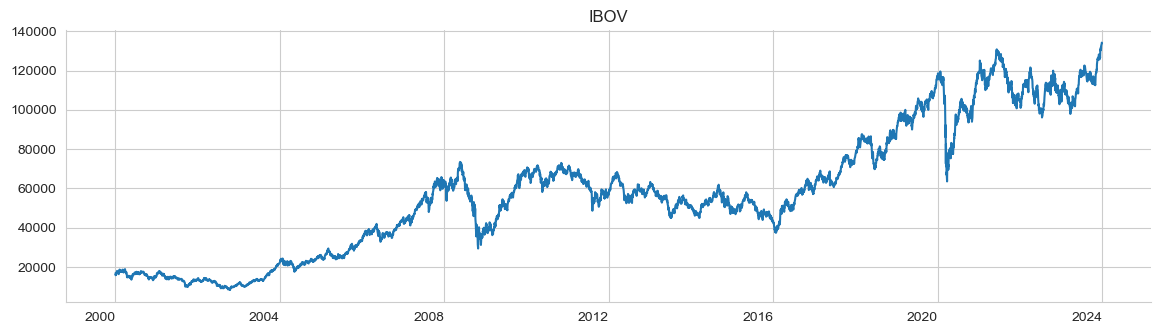

In [6]:
#===============================================================================================================================
# DATA: PLOT
#===============================================================================================================================
ax = df.plot(title=seriesId, legend=False, figsize=(14, 4), rot=0)
ax.set_xlabel('')
sns.despine()

In [7]:
#===============================================================================================================================
# DATA: STANDARD - SCALE -TRAIN
#===============================================================================================================================
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
df_scaled = pd.Series(scaler.fit_transform(df[:'2022']).squeeze(), index=df[:'2022'].index)
df_scaled

Date
2000-01-03   -1.259400
2000-01-04   -1.294587
2000-01-05   -1.281739
2000-01-06   -1.286246
2000-01-07   -1.279652
                ...   
2022-12-23    1.764666
2022-12-26    1.733377
2022-12-27    1.728176
2022-12-28    1.782241
2022-12-29    1.765873
Length: 5695, dtype: float64

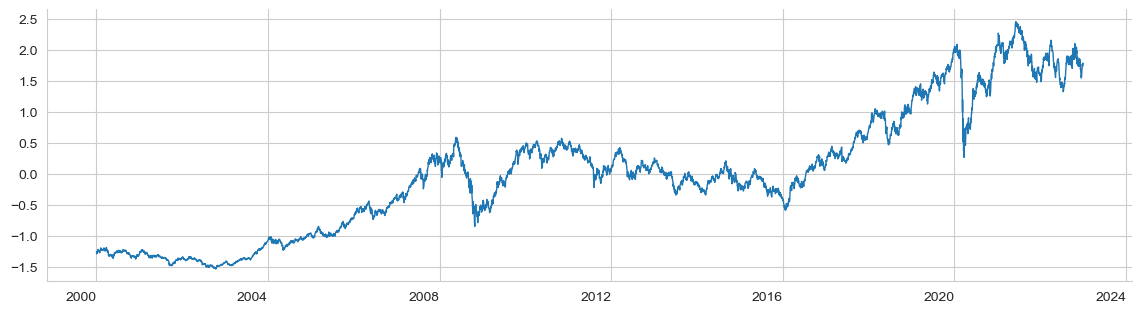

In [8]:
#===============================================================================================================================
# DATA: STANDARD - PLOT
#===============================================================================================================================
ax = df_scaled.plot(lw=1, figsize=(14, 4), rot=0)
ax.set_xlabel('')
sns.despine()

In [9]:
#===============================================================================================================================
# DATA: STANDARD - SCALE - TEST
#===============================================================================================================================
df_scaledtest = pd.Series(scaler.transform(df['2022-12-01':]).squeeze(), index=df['2022-12-01':].index)
df_scaledtest

Date
2022-12-01    1.804698
2022-12-02    1.837242
2022-12-05    1.755011
2022-12-06    1.780672
2022-12-07    1.744161
                ...   
2023-12-21    2.497624
2023-12-22    2.516235
2023-12-26    2.541661
2023-12-27    2.563202
2023-12-28    2.562926
Length: 269, dtype: float64

In [10]:
#===============================================================================================================================
# DATA PREP: RECURRENT SEQUENCES - FUNCTION
#===============================================================================================================================
def create_univariate_rnn_data(data, window_size):
    n = len(data)
    y = data[window_size:]
    #y = data[window_size-1:]
    data = data.values.reshape(-1, 1) # make 2D
    X = np.hstack(tuple([data[i: n-j, :] for i, j in enumerate(range(window_size, 0, -1))]))
    #X = np.hstack(tuple([data[i: n-j+1, :] for i, j in enumerate(range(window_size, 0, -1))]))
    return pd.DataFrame(X, index=y.index), y

In [11]:
#===============================================================================================================================
# DATA PREP: RECURRENT SEQUENCES - TRAIN
#===============================================================================================================================
X, y = create_univariate_rnn_data(df_scaled, window_size=window_size)
X


,0,1,2,3,4,5,6,7,8,9,...,11,12,13,14,15,16,17,18,19,20
Date,,,,,,,,,,,,,,,,,,,,,
2000-02-02,-1.259400,-1.294587,-1.281739,-1.286246,-1.279652,-1.256410,-1.271060,-1.269621,-1.247415,-1.235684,...,-1.227688,-1.241803,-1.251371,-1.256017,-1.258053,-1.253700,-1.254486,-1.265790,-1.277073,-1.272707
2000-02-03,-1.294587,-1.281739,-1.286246,-1.279652,-1.256410,-1.271060,-1.269621,-1.247415,-1.235684,-1.222798,...,-1.241803,-1.251371,-1.256017,-1.258053,-1.253700,-1.254486,-1.265790,-1.277073,-1.272707,-1.261420
2000-02-04,-1.281739,-1.286246,-1.279652,-1.256410,-1.271060,-1.269621,-1.247415,-1.235684,-1.222798,-1.227688,...,-1.251371,-1.256017,-1.258053,-1.253700,-1.254486,-1.265790,-1.277073,-1.272707,-1.261420,-1.242230
2000-02-07,-1.286246,-1.279652,-1.256410,-1.271060,-1.269621,-1.247415,-1.235684,-1.222798,-1.227688,-1.241803,...,-1.256017,-1.258053,-1.253700,-1.254486,-1.265790,-1.277073,-1.272707,-1.261420,-1.242230,-1.226735
2000-02-08,-1.279652,-1.256410,-1.271060,-1.269621,-1.247415,-1.235684,-1.222798,-1.227688,-1.241803,-1.251371,...,-1.258053,-1.253700,-1.254486,-1.265790,-1.277073,-1.272707,-1.261420,-1.242230,-1.226735,-1.220439
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-12-23,1.834218,1.741167,1.734825,1.804176,1.855565,1.804698,1.837242,1.755011,1.780672,1.744161,...,1.693666,1.622724,1.563928,1.570646,1.570383,1.541631,1.603049,1.672299,1.690849,1.694708
2022-12-26,1.741167,1.734825,1.804176,1.855565,1.804698,1.837242,1.755011,1.780672,1.744161,1.684847,...,1.622724,1.563928,1.570646,1.570383,1.541631,1.603049,1.672299,1.690849,1.694708,1.764666
2022-12-27,1.734825,1.804176,1.855565,1.804698,1.837242,1.755011,1.780672,1.744161,1.684847,1.693666,...,1.563928,1.570646,1.570383,1.541631,1.603049,1.672299,1.690849,1.694708,1.764666,1.733377


In [12]:
#===============================================================================================================================
# DATA PREP: TRAIN
#===============================================================================================================================
X_train = X[:'2022'].values.reshape(-1, window_size, 1)
y_train = y[:'2022']

In [13]:
#===============================================================================================================================
# DATA PREP: RECURRENT SEQUENCES - TEST
#===============================================================================================================================
Xtest, ytest = create_univariate_rnn_data(df_scaledtest, window_size=window_size)
Xtest


,0,1,2,3,4,5,6,7,8,9,...,11,12,13,14,15,16,17,18,19,20
Date,,,,,,,,,,,,,,,,,,,,,
2023-01-02,1.804698,1.837242,1.755011,1.780672,1.744161,1.684847,1.693666,1.622724,1.563928,1.570646,...,1.541631,1.603049,1.672299,1.690849,1.694708,1.764666,1.733377,1.728176,1.782241,1.765873
2023-01-03,1.837242,1.755011,1.780672,1.744161,1.684847,1.693666,1.622724,1.563928,1.570646,1.570383,...,1.603049,1.672299,1.690849,1.694708,1.764666,1.733377,1.728176,1.782241,1.765873,1.656388
2023-01-04,1.755011,1.780672,1.744161,1.684847,1.693666,1.622724,1.563928,1.570646,1.570383,1.541631,...,1.672299,1.690849,1.694708,1.764666,1.733377,1.728176,1.782241,1.765873,1.656388,1.584337
2023-01-05,1.780672,1.744161,1.684847,1.693666,1.622724,1.563928,1.570646,1.570383,1.541631,1.603049,...,1.690849,1.694708,1.764666,1.733377,1.728176,1.782241,1.765873,1.656388,1.584337,1.622435
2023-01-06,1.744161,1.684847,1.693666,1.622724,1.563928,1.570646,1.570383,1.541631,1.603049,1.672299,...,1.694708,1.764666,1.733377,1.728176,1.782241,1.765873,1.656388,1.584337,1.622435,1.697635
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-12-21,2.297251,2.314868,2.280364,2.287346,2.313648,2.301499,2.339492,2.367325,2.322270,2.325544,...,2.296412,2.331749,2.325973,2.309238,2.409056,2.453944,2.432919,2.461824,2.486830,2.452708
2023-12-22,2.314868,2.280364,2.287346,2.313648,2.301499,2.339492,2.367325,2.322270,2.325544,2.283799,...,2.331749,2.325973,2.309238,2.409056,2.453944,2.432919,2.461824,2.486830,2.452708,2.497624
2023-12-26,2.280364,2.287346,2.313648,2.301499,2.339492,2.367325,2.322270,2.325544,2.283799,2.296412,...,2.325973,2.309238,2.409056,2.453944,2.432919,2.461824,2.486830,2.452708,2.497624,2.516235


In [14]:
#===============================================================================================================================
# DATA PREP: TEST
#===============================================================================================================================
X_test = Xtest['2023':].values.reshape(-1, window_size, 1)
y_test = ytest['2023':]

X_train.shape, y_train.shape, X_test.shape, y_test.shape

((5674, 21, 1), (5674,), (248, 21, 1), (248,))

In [15]:
#===============================================================================================================================
# DATA PREP: OBS, WINDOWS, FEATURES
#===============================================================================================================================
n_obs, window_size, n_features = X_train.shape
n_obs, window_size, n_features

(5674, 21, 1)

In [16]:
#===============================================================================================================================
# MODEL: LSTM
#===============================================================================================================================
rnn = Sequential([
    LSTM(units=10, input_shape=(window_size, n_features), name='LSTM'),
    Dense(1, name='Output')
])

rnn.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 LSTM (LSTM)                 (None, 10)                480       
                                                                 
 Output (Dense)              (None, 1)                 11        
                                                                 
Total params: 491 (1.92 KB)
Trainable params: 491 (1.92 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [17]:
#===============================================================================================================================
# MODEL: CONFIG
#===============================================================================================================================
optimizer = keras.optimizers.RMSprop(learning_rate=0.001, rho=0.9, epsilon=1e-08, weight_decay=0.0)

rnn.compile(loss='mean_squared_error', optimizer=optimizer)

rnn_path = (results_path / 'LSTM-Jansen-Standard-Daily-rnn.h5').as_posix()
checkpointer = ModelCheckpoint(filepath=rnn_path, verbose=1, monitor='val_loss', save_best_only=True)

early_stopping = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)

In [18]:
#===============================================================================================================================
# MODEL: TRAIN
#===============================================================================================================================
lstm_training = rnn.fit(X_train, y_train, epochs=150, batch_size=20, shuffle=True, 
                        validation_data=(X_test, y_test), 
                        callbacks=[early_stopping, checkpointer],verbose=1)

Epoch 1/150

282/284 [============================>.] - ETA: 0s - loss: 0.1391
Epoch 1: val_loss improved from inf to 0.01212, saving model to Data/Output/Jansen-LSTM-Standard-Daily\LSTM-Jansen-Standard-Daily-rnn.h5
284/284 [==============================] - 11s 19ms/step - loss: 0.1383 - val_loss: 0.0121
Epoch 2/150
282/284 [============================>.] - ETA: 0s - loss: 0.0031
Epoch 2: val_loss improved from 0.01212 to 0.00697, saving model to Data/Output/Jansen-LSTM-Standard-Daily\LSTM-Jansen-Standard-Daily-rnn.h5
284/284 [==============================] - 4s 15ms/step - loss: 0.0031 - val_loss: 0.0070
Epoch 3/150
282/284 [============================>.] - ETA: 0s - loss: 0.0023
Epoch 3: val_loss improved from 0.00697 to 0.00425, saving model to Data/Output/Jansen-LSTM-Standard-Daily\LSTM-Jansen-Standard-Daily-rnn.h5
284/284 [==============================] - 4s 13ms/step - loss: 0.0023 - val_loss: 0.0042
Epoch 4/150
284/284 [==============================] - ETA: 0s - loss: 0.00

280/284 [============================>.] - ETA: 0s - loss: 0.0012
Epoch 32: val_loss did not improve from 0.00171
284/284 [==============================] - 4s 15ms/step - loss: 0.0012 - val_loss: 0.0022
Epoch 33/150
284/284 [==============================] - ETA: 0s - loss: 0.0012
Epoch 33: val_loss improved from 0.00171 to 0.00170, saving model to Data/Output/Jansen-LSTM-Standard-Daily\LSTM-Jansen-Standard-Daily-rnn.h5
284/284 [==============================] - 5s 17ms/step - loss: 0.0012 - val_loss: 0.0017
Epoch 34/150
281/284 [============================>.] - ETA: 0s - loss: 0.0012
Epoch 34: val_loss did not improve from 0.00170
284/284 [==============================] - 5s 18ms/step - loss: 0.0012 - val_loss: 0.0019
Epoch 35/150
284/284 [==============================] - ETA: 0s - loss: 0.0012
Epoch 35: val_loss did not improve from 0.00170
284/284 [==============================] - 5s 16ms/step - loss: 0.0012 - val_loss: 0.0020
Epoch 36/150
280/284 [============================>

284/284 [==============================] - 3s 12ms/step - loss: 0.0011 - val_loss: 0.0017
Epoch 69/150
282/284 [============================>.] - ETA: 0s - loss: 0.0011
Epoch 69: val_loss did not improve from 0.00166
284/284 [==============================] - 4s 14ms/step - loss: 0.0011 - val_loss: 0.0017
Epoch 70/150
284/284 [==============================] - ETA: 0s - loss: 0.0011
Epoch 70: val_loss did not improve from 0.00166
284/284 [==============================] - 4s 13ms/step - loss: 0.0011 - val_loss: 0.0017
Epoch 71/150
281/284 [============================>.] - ETA: 0s - loss: 0.0011
Epoch 71: val_loss did not improve from 0.00166
284/284 [==============================] - 3s 11ms/step - loss: 0.0011 - val_loss: 0.0019
Epoch 72/150
282/284 [============================>.] - ETA: 0s - loss: 0.0011
Epoch 72: val_loss did not improve from 0.00166
284/284 [==============================] - 3s 11ms/step - loss: 0.0011 - val_loss: 0.0018
Epoch 73/150
284/284 [====================

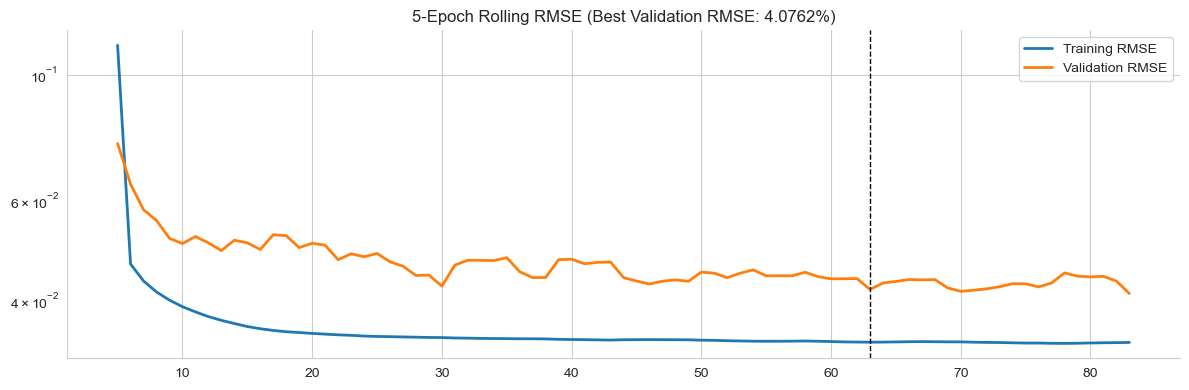

In [19]:
#===============================================================================================================================
# RESULTS - PERFORMANCE vs EPOCHS - TRAIN, VALIDATION
#===============================================================================================================================
fig, ax = plt.subplots(figsize=(12, 4))

loss_history = pd.DataFrame(lstm_training.history).pow(.5)
loss_history.index += 1
best_rmse = loss_history.val_loss.min()

best_epoch = loss_history.val_loss.idxmin()

title = f'5-Epoch Rolling RMSE (Best Validation RMSE: {best_rmse:.4%})'
loss_history.columns=['Training RMSE', 'Validation RMSE']
loss_history.rolling(5).mean().plot(logy=True, lw=2, title=title, ax=ax)

ax.axvline(best_epoch, ls='--', lw=1, c='k')

sns.despine()
fig.tight_layout()
fig.savefig(results_path / 'rnn_error', dpi=300);

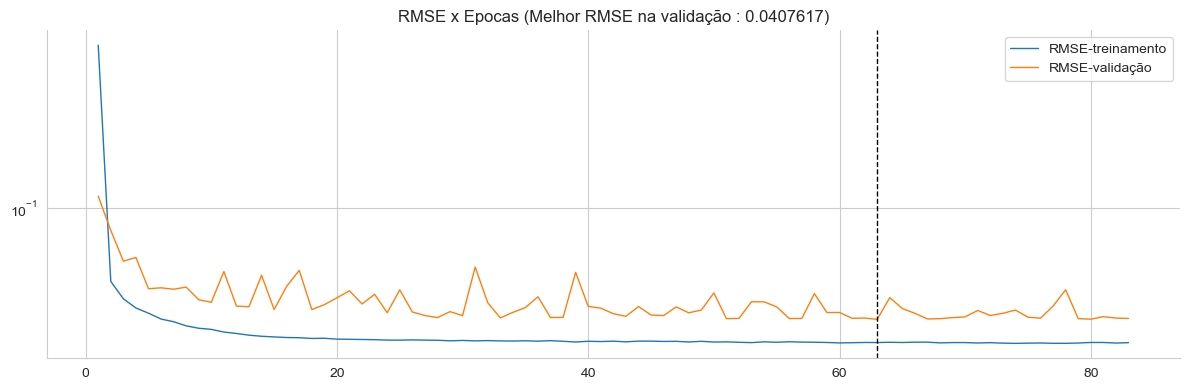

In [20]:
#===============================================================================================================================
# RESULTS - PERFORMANCE vs EPOCHS - TRAIN, VALIDATION
#===============================================================================================================================
fig, ax = plt.subplots(figsize=(12, 4))

loss_history = pd.DataFrame(lstm_training.history).pow(.5)
loss_history.index += 1
best_rmse = loss_history.val_loss.min()

best_epoch = loss_history.val_loss.idxmin()

title = f'RMSE x Epocas (Melhor RMSE na validação : {best_rmse:.6})'
loss_history.columns=['RMSE-treinamento', 'RMSE-validação']
loss_history.rolling(1).mean().plot(logy=True, lw=1, title=title, ax=ax)

ax.axvline(best_epoch, ls='--', lw=1, c='k')

sns.despine()
fig.tight_layout()
fig.savefig(results_path / 'rnn_error', dpi=300);

In [21]:
#===============================================================================================================================
# RESULTS - PERFORMANCE - TRAIN, TEST
#===============================================================================================================================
train_rmse_scaled = np.sqrt(rnn.evaluate(X_train, y_train, verbose=0))
test_rmse_scaled = np.sqrt(rnn.evaluate(X_test, y_test, verbose=0))
print(f'Train RMSE: {train_rmse_scaled:.4f} | Test RMSE: {test_rmse_scaled:.4f}')
#-------------------------------------------------------------------------------------------------------------------------------
# Train RMSE: 0.0327 | Test RMSE: 0.0396
#-------------------------------------------------------------------------------------------------------------------------------

Train RMSE: 0.0333 | Test RMSE: 0.0408


In [22]:
#===============================================================================================================================
# RESULTS - FORECAST - TRAIN, TEST
#===============================================================================================================================
train_predict_scaled = rnn.predict(X_train)
test_predict_scaled = rnn.predict(X_test)

8/8 [==============================] - 0s 6ms/step


In [23]:
#===============================================================================================================================
# RESULTS - SPEARMAN IC - TRAIN, TEST
#===============================================================================================================================
train_ic = spearmanr(y_train, train_predict_scaled)[0]
test_ic = spearmanr(y_test, test_predict_scaled)[0]
print(f'Train IC: {train_ic:.6f} | Test IC: {test_ic:.4f}')
#-------------------------------------------------------------------------------------------------------------------------------
# Train IC: 0.999200 | Test IC: 0.9794
#-------------------------------------------------------------------------------------------------------------------------------

Train IC: 0.999201 | Test IC: 0.9815


In [24]:
#===============================================================================================================================
# RESULTS - FORECAST - RESULTS
#===============================================================================================================================
np.savetxt('Data/Output/LSTM-Jansen-Standard-Daily-Scaled-Train.txt', train_predict_scaled, delimiter=';')
np.savetxt('Data/Output/LSTM-Jansen-Standard-Daily-Scaled-Test.txt' , test_predict_scaled, delimiter =';')
test_predict_scaled[:,0]

array([1.779974 , 1.6800011, 1.5988237, 1.624693 , 1.6983736, 1.7457372,
       1.7544608, 1.8017209, 1.8581492, 1.848409 , 1.8182167, 1.7656353,
       1.8206588, 1.8550075, 1.8769767, 1.8547962, 1.841264 , 1.8760688,
       1.9173807, 1.920748 , 1.867704 , 1.8566624, 1.8895345, 1.8579167,
       1.7952586, 1.7393564, 1.7380722, 1.714388 , 1.7697796, 1.7250755,
       1.7161899, 1.7392249, 1.7156194, 1.7602829, 1.7795092, 1.7590998,
       1.6969984, 1.7005205, 1.6526531, 1.6413281, 1.6190538, 1.5995096,
       1.5662374, 1.5775541, 1.6053021, 1.5952783, 1.6592354, 1.6285386,
       1.5780004, 1.5577437, 1.5519054, 1.5441883, 1.5651565, 1.5259697,
       1.4873453, 1.4860085, 1.4647073, 1.3927187, 1.4103744, 1.4417254,
       1.4897162, 1.5132276, 1.570998 , 1.525982 , 1.5055107, 1.5163275,
       1.4927694, 1.4836879, 1.5136445, 1.6450046, 1.6842834, 1.6717978,
       1.6636302, 1.656179 , 1.6598164, 1.5950862, 1.5971998, 1.588321 ,
       1.5645841, 1.5340304, 1.5481064, 1.5955971, 

In [25]:
#===============================================================================================================================
# RESULTS - PRICE - RECOVER - PRED - TRAIN, TEST
#===============================================================================================================================
train_predict = pd.Series(scaler.inverse_transform(train_predict_scaled).squeeze(), index=y_train.index)
test_predict = (pd.Series(scaler.inverse_transform(test_predict_scaled).squeeze(), index=y_test.index))

np.savetxt('Data/Output/LSTM-Jansen-Standard-Daily-Train.txt', train_predict, delimiter=';')
np.savetxt('Data/Output/LSTM-Jansen-Standard-Daily-Test.txt' , test_predict, delimiter =';')

test_predict

Date
2023-01-02    110167.164062
2023-01-03    107100.367188
2023-01-04    104610.148438
2023-01-05    105403.718750
2023-01-06    107663.968750
                  ...      
2023-12-21    130828.328125
2023-12-22    131675.296875
2023-12-26    132334.000000
2023-12-27    133025.171875
2023-12-28    133655.500000
Length: 248, dtype: float32

In [26]:
#===============================================================================================================================
# RESULTS - PRICE - PRED - EXPORT
#===============================================================================================================================
dftest_predict=test_predict.to_frame()
dftest_predict


,0
Date,
2023-01-02,110167.164062
2023-01-03,107100.367188
2023-01-04,104610.148438
2023-01-05,105403.718750
2023-01-06,107663.968750
...,...
2023-12-21,130828.328125
2023-12-22,131675.296875
2023-12-26,132334.000000


In [27]:
#===============================================================================================================================
# RESULTS - PRICE - RECOVER - TARGET - TRAIN, TEST
#===============================================================================================================================
y_train_rescaled = scaler.inverse_transform(y_train.to_frame()).squeeze()
y_test_rescaled = scaler.inverse_transform(y_test.to_frame()).squeeze()

y_test_rescaled

array([106376.02, 104165.74, 105334.46, 107641.32, 108963.7 , 109129.57,
       110816.71, 112517.08, 111850.22, 110916.08, 109212.66, 111439.12,
       112228.39, 112921.88, 112040.64, 111737.28, 113028.15, 114270.07,
       114177.55, 112316.16, 112273.01, 113430.54, 112073.55, 110140.64,
       108523.47, 108721.58, 107829.73, 109951.49, 108008.05, 108078.27,
       108836.47, 107848.81, 109600.14, 109941.46, 109176.92, 107152.05,
       107592.87, 105798.43, 105711.05, 104931.93, 104384.67, 103325.61,
       103865.99, 104700.32, 104227.93, 106540.32, 105071.19, 103618.2 ,
       103121.36, 102932.38, 102675.45, 103434.66, 101981.53, 100922.89,
       100998.13, 100220.63,  97926.34,  98829.27,  99670.47, 101185.09,
       101792.52, 103713.45, 101882.2 , 101506.18, 101869.45, 100977.85,
       100821.73, 101846.64, 106213.76, 106889.71, 106457.85, 106279.37,
       106015.67, 106163.23, 103912.94, 104366.82, 103946.58, 103220.09,
       102312.1 , 102923.31, 104431.63, 101926.95, 

In [28]:
#===============================================================================================================================
# RESULTS - PRICE - PERFORMANCE - TRAIN, TEST
#===============================================================================================================================
train_rmse = np.sqrt(mean_squared_error(train_predict, y_train_rescaled))
test_rmse = np.sqrt(mean_squared_error(test_predict, y_test_rescaled))
f'Train RMSE: {train_rmse:.2f} | Test RMSE: {test_rmse:.2f}'
#-------------------------------------------------------------------------------------------------------------------------------
# 'Train RMSE: 1004.22 | Test RMSE: 1216.12'
#-------------------------------------------------------------------------------------------------------------------------------

'Train RMSE: 1022.18 | Test RMSE: 1250.42'

In [29]:
#===============================================================================================================================
# RESULTS - PRICE - STORE - TRAIN, TEST
#===============================================================================================================================
df['Train Predictions'] = train_predict
df['Test Predictions'] = test_predict

temp = pd.concat([train_predict.to_frame('predictions').assign(data='Train'), test_predict.to_frame('predictions').assign(data='Test')])
df['predictions'] = temp['predictions']
df['data']        = temp['data']

df['2022-12-29':]

,Close,Train Predictions,Test Predictions,predictions,data
Date,,,,,
2022-12-29,109734.60,110325.523438,NaN,110325.523438,Train
2023-01-02,106376.02,NaN,110167.164062,110167.164062,Test
2023-01-03,104165.74,NaN,107100.367188,107100.367188,Test
2023-01-04,105334.46,NaN,104610.148438,104610.148438,Test
2023-01-05,107641.32,NaN,105403.718750,105403.718750,Test
...,...,...,...,...,...
2023-12-21,132182.01,NaN,130828.328125,130828.328125,Test
2023-12-22,132752.93,NaN,131675.296875,131675.296875,Test
2023-12-26,133532.92,NaN,132334.000000,132334.000000,Test


In [30]:
#===============================================================================================================================
# RESULTS - PRICE - EXPORT
#===============================================================================================================================
df.to_excel('Data/Output/LSTM-Jansen-Standard-Daily.xlsx')

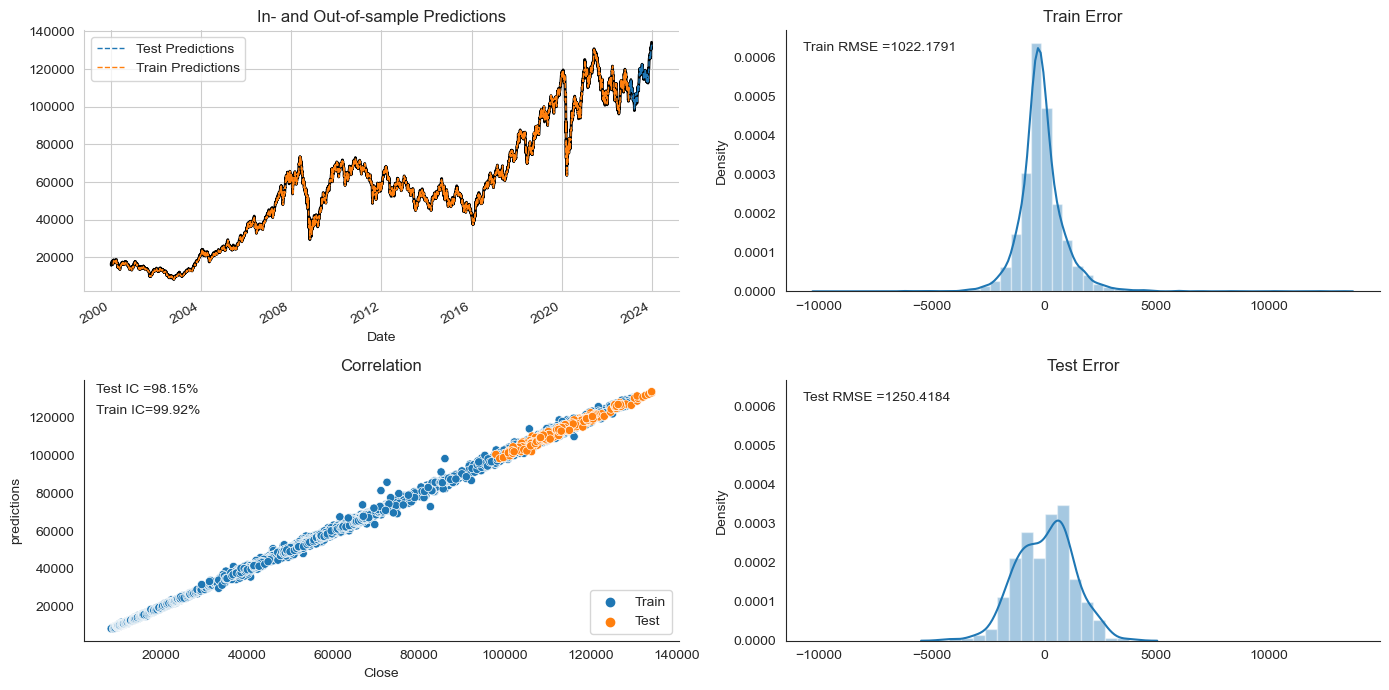

In [31]:
#===============================================================================================================================
# RESULTS - PRICE - PLOT
#===============================================================================================================================

fig=plt.figure(figsize=(14,7))
ax1 = plt.subplot(221)

df.loc['2000':, 'Close'].plot(lw=2, ax=ax1, c='k')
df.loc['2000':, 'predictions'].plot(lw=1.5, ax=ax1, c='k')
df.loc['2000':, ['Test Predictions', 'Train Predictions']].plot(lw=1, ax=ax1, ls='--')
ax1.set_title('In- and Out-of-sample Predictions')

with sns.axes_style("white"):
    ax3 = plt.subplot(223)
    sns.scatterplot(x='Close', y='predictions', data=df, hue='data', ax=ax3)
    ax3.text(x=.02, y=.95, s=f'Test IC ={test_ic:.2%}', transform=ax3.transAxes)
    ax3.text(x=.02, y=.87, s=f'Train IC={train_ic:.2%}', transform=ax3.transAxes)
    ax3.set_title('Correlation')
    ax3.legend(loc='lower right')
    
    ax2 = plt.subplot(222)
    ax4 = plt.subplot(224, sharex = ax2, sharey=ax2)
    sns.distplot(train_predict.squeeze()- y_train_rescaled, ax=ax2)
    ax2.set_title('Train Error')
    ax2.text(x=.03, y=.92, s=f'Train RMSE ={train_rmse:.4f}', transform=ax2.transAxes)
    sns.distplot(test_predict.squeeze()-y_test_rescaled, ax=ax4)
    ax4.set_title('Test Error')
    ax4.text(x=.03, y=.92, s=f'Test RMSE ={test_rmse:.4f}', transform=ax4.transAxes)

sns.despine()
fig.tight_layout()
fig.savefig(results_path / 'rnn_regression', dpi=300);
